# Train and validate TSMC-Net

RSAT=0.01 and 90 spectra per class

In [5]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_global_generator(42)

tf.random.set_seed(42)  
# tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)

from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names
from oneida_utils import simple_spectrum_fig, simple_plot_raw_scores, plot_spectrum_with_scores, multiclass_roc_auc_score, multiclass_sensitivity_specificity_score, multiclass_sensitivity_threshold_score
from oneida_scoring_tools import calc_AMCAS, is_cui_present, is_cui_present_in_mult
from aimos.misc.utils import classifier_internals
from aimos.misc.utils import clf_post_processor
from oneida_utils import mixture_names_to_one_hot_encode
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from oneida_grad_cam import grad_cam

from stats import stats
stats(n_compounds=8)

Total 1-C combinations: 8
Total 2-C combinations: 28
Total 3-C combinations: 56
Total 4-C combinations: 70
Total 5-C combinations: 56
Total 6-C combinations: 28
Total 7-C combinations: 8
Total 8-C combinations: 1
Total combinations: 255


# Retrieve training(D)+ validation(V) mixtures and its variables

In [6]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print('reduced_labels', reduced_labels)


# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

final_neuron_number = np.unique(y, axis=0).shape[0]
print('Number of neurons in the final layer :', final_neuron_number)

print('labels from class:', m.labels)

Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
reduced_labels ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']
Number of neurons in the final layer : 255
labels from class: ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HCOOH$' '$CH_3CHO$+$CH_3CN$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN

In [8]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_val shape: (9180, 229, 1)
y_ohe_val shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [9]:
from oneida_model import get_callbacks, get_optimizer, compile_and_fit, TSMCN_12_L_229

In [10]:
model = TSMCN_12_L_229()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv1D)                 (None, 227, 3)            12        
                                                                 
 S2 (AveragePooling1D)       (None, 113, 3)            0         
                                                                 
 C3 (Conv1D)                 (None, 111, 3)            30        
                                                                 
 S4 (AveragePooling1D)       (None, 55, 3)             0         
                                                                 
 C5 (Conv1D)                 (None, 53, 3)             30        
                                                                 
 flatten (Flatten)           (None, 159)               0         
                                                                 
 dense (Dense)               (None, 275)               4

2022-11-29 22:30:09.301359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 22:30:09.301515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 22:30:09.301611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 22:30:09.304019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuso

In [11]:
# tf.keras.utils.plot_model(model, to_file="RESULTS/TSMCN_8_L_229.png", show_shapes=True, rankdir='TB', dpi=150)

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_name = data_filename.split('.pkl')[0].split('/')[1]
print(model_name)

TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90


In [13]:
# run on CPU for reproducibility, best epoch is 4.
# with tf.device('/CPU:0'):
#      stop_early = tf.keras.callbacks.EarlyStopping(monitor='SparseCatCrossentropy', patience=5)
#     history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[stop_early])

# LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
with tf.device('/CPU:0'):
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='SparseCatCrossentropy', patience=5)
    history = model.fit(x_train, y_train, batch_size=32, epochs=40, validation_data=(x_val, y_val), 
                        callbacks=[model_checkpoint_callback, stop_early],
)



Epoch 1/40
431/431 [==============================] - 5s 11ms/step - loss: 3.5902 - SparseCatCrossentropy: 3.5880 - accuracy: 0.1279 - val_loss: 1.9684 - val_SparseCatCrossentropy: 1.9684 - val_accuracy: 0.3577
Epoch 2/40
431/431 [==============================] - 4s 10ms/step - loss: 1.2309 - SparseCatCrossentropy: 1.2299 - accuracy: 0.5730 - val_loss: 0.8607 - val_SparseCatCrossentropy: 0.8606 - val_accuracy: 0.6833
Epoch 3/40
431/431 [==============================] - 4s 9ms/step - loss: 0.5666 - SparseCatCrossentropy: 0.5662 - accuracy: 0.8085 - val_loss: 0.6709 - val_SparseCatCrossentropy: 0.6708 - val_accuracy: 0.7895
Epoch 4/40
431/431 [==============================] - 4s 9ms/step - loss: 0.3566 - SparseCatCrossentropy: 0.3563 - accuracy: 0.8802 - val_loss: 0.3483 - val_SparseCatCrossentropy: 0.3482 - val_accuracy: 0.8786
Epoch 5/40
431/431 [==============================] - 4s 9ms/step - loss: 0.2984 - SparseCatCrossentropy: 0.2980 - accuracy: 0.8988 - val_loss: 0.2712 - val_S

In [15]:
#Sklearn model saving and loading
from joblib import dump, load
import datetime
from datetime import date, datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_time_%H-%M-%S")
model.save('model/' + model_name + '_' + dt_string + '.hdf5')
np.save('model/' + model_name + '_' + dt_string + 'history' + '.npy',history.history)
np.save('model/' + model_name + '_' + dt_string + 'epoch' + '.npy',history.epoch)


In [16]:
# model = tf.keras.models.load_model('model/' + model_name + '_' + dt_string + '.hdf5', compile=False)


In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_val)

287/287 [==============================] - 1s 3ms/step


In [18]:
y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')
y_train_ohe = y_ohe[train_indices]
y_val_ohe = y_ohe[val_indices]
y_train_ohe_tensor = tf.convert_to_tensor(y_train_ohe, np.int64)
y_val_ohe_tensor = tf.convert_to_tensor(y_val_ohe, np.int64)

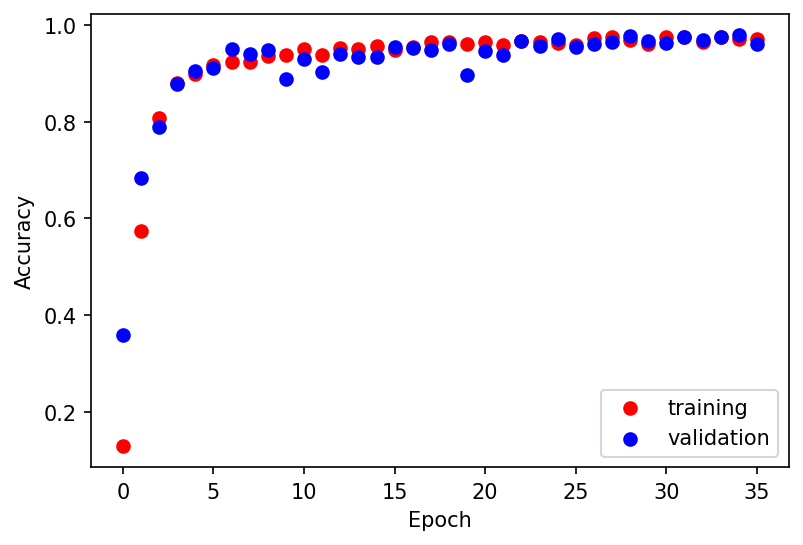

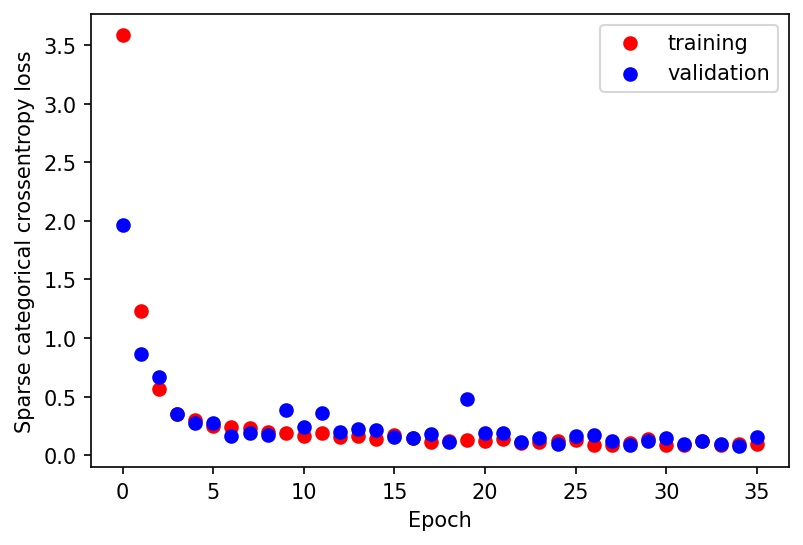

In [19]:
plt.figure(dpi=150)
plt.scatter(history.epoch,history.history['accuracy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend(loc=4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(r'RESULTS/results_figures/' + model_name + '_accuracies.png', bbox_inches='tight')

plt.figure(dpi=150)
plt.scatter(history.epoch,history.history['SparseCatCrossentropy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_SparseCatCrossentropy'],color = 'blue', label = 'validation')
plt.legend(loc=1)
plt.xlabel('Epoch')
plt.ylabel('Sparse categorical crossentropy loss')
plt.savefig(r'RESULTS/results_figures/'+ model_name + '_sparse_cat_losses.png', bbox_inches='tight')

loss is minimized and training was stopped early since train and validation accuracies are nearly equal

notebook ends!